# Imports and configurations

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [7]:
from sklearn.metrics import r2_score

In [94]:
import pickle

In [8]:
from time import time

In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

C:\Users\Rzeczy\AppData\Local\Temp\ipykernel_3764\4081935049.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Data load

In [10]:
ratings = pd.read_csv('data/ratings.csv', 
                      delimiter=';', 
                      quotechar='"', 
                      encoding='latin1', 
                      header=0,
                     )

In [11]:
users = pd.read_csv('data/users.csv', 
                    delimiter=';', 
                    quotechar='"', 
                    encoding='latin1', 
                    header=0, 
                   )

In [12]:
books = pd.read_csv('data/books.csv', 
                    delimiter=';', 
                    quotechar='"', 
                    encoding='latin1', 
                    header=0, 
                    error_bad_lines=False, 
                    warn_bad_lines=True,
                   )  # skipping a few lines which cause error during reading the 'books.csv'

C:\Users\Rzeczy\AppData\Local\Temp\ipykernel_3764\1829374821.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('data/books.csv',
C:\Users\Rzeczy\AppData\Local\Temp\ipykernel_3764\1829374821.py:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('data/books.csv',
b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: e

# Data analysis and initial preprocessing

In [13]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### Users' location may be converted to a country only to be more informative

In [14]:
users['Location'] = users['Location'].apply(lambda x: x.split(',')[-1].strip())

In [15]:
users.head()

,User-ID,Location,Age
0,1,usa,NaN
1,2,usa,18.0
2,3,russia,NaN
3,4,portugal,17.0
4,5,united kingdom,NaN


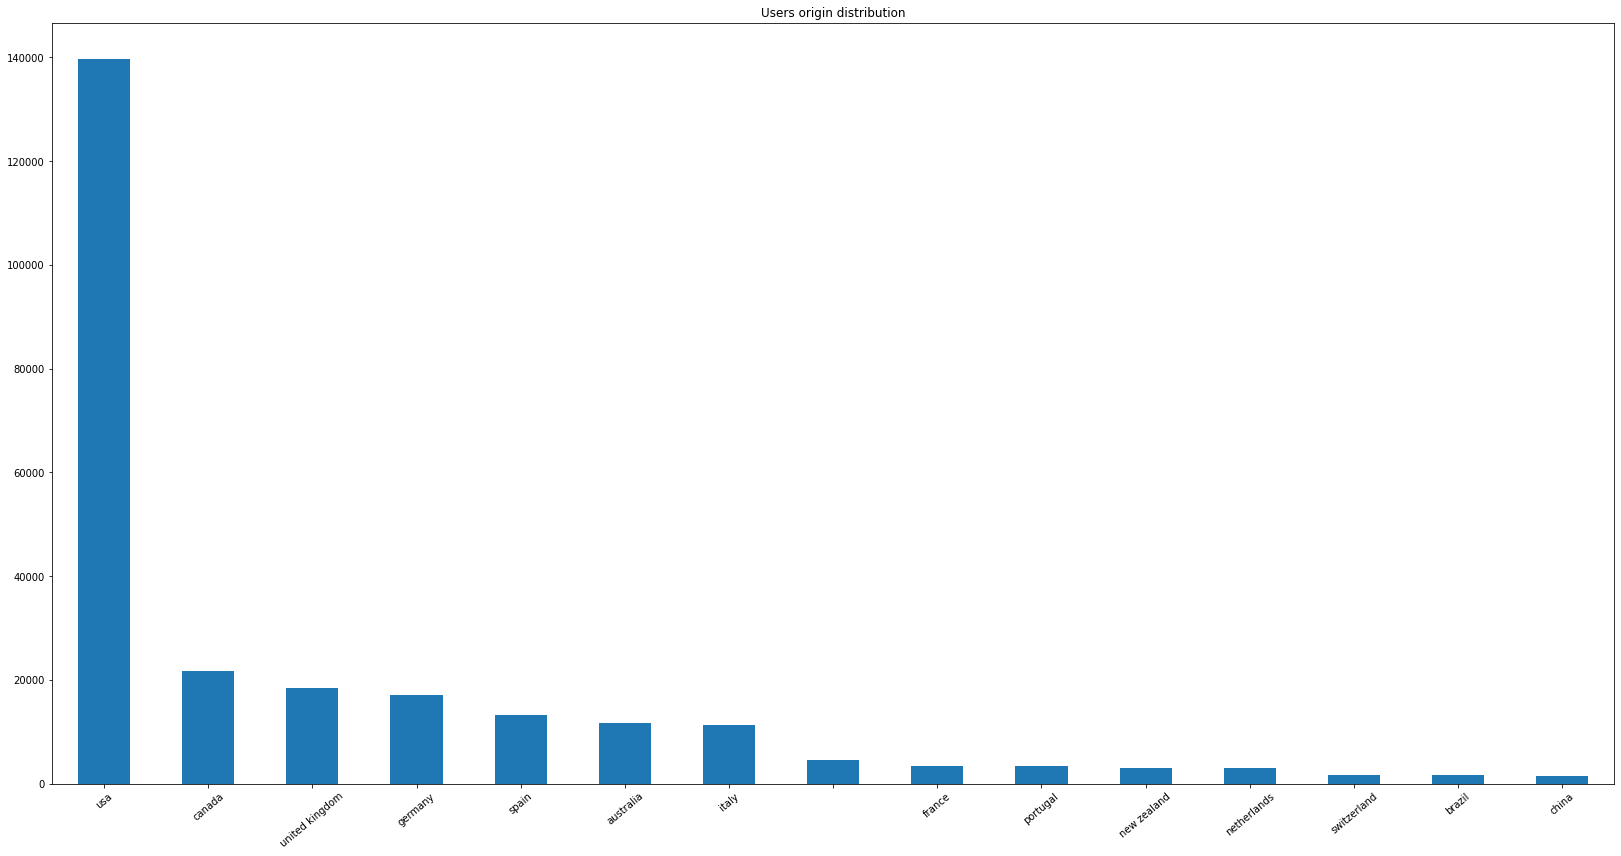

In [16]:
plt.figure(figsize=(28, 14))
users['Location'].value_counts()[:15].plot(kind='bar', rot=40)  # showing only top 15 countries as a graph wouldn't readible
plt.title('Users origin distribution')
plt.show()

### It can be seen that most users come from USA. Also, there are few users who do not have any country related

In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


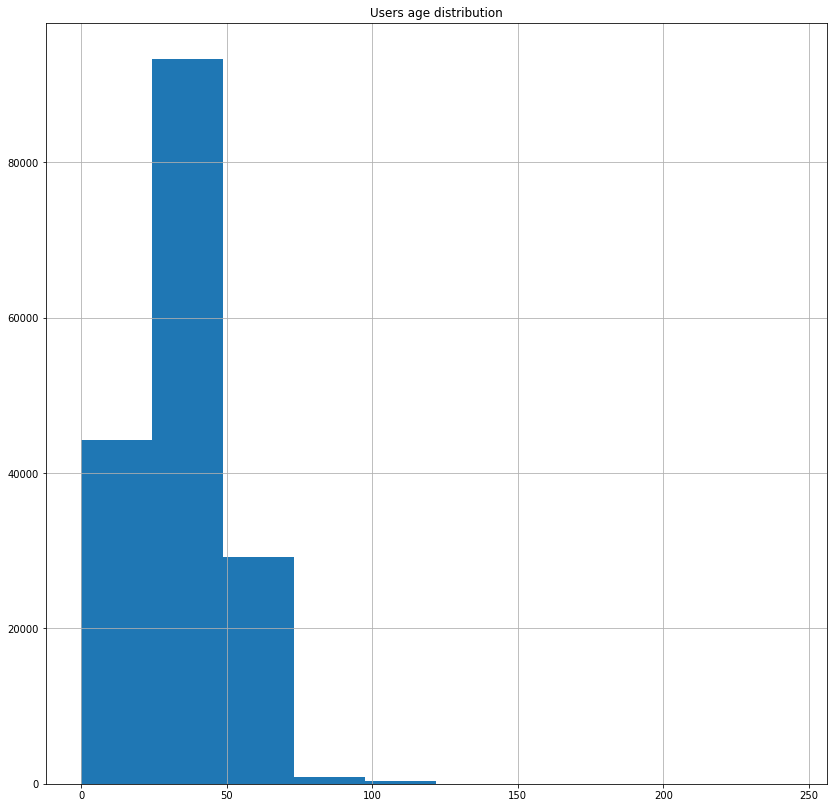

In [18]:
plt.figure(figsize=(14, 14))
users['Age'].hist()  
plt.title('Users age distribution')
plt.show()

### A lot of users do not have an age associated with them, which could be a meaningful metric. As for remaining ones, it may be seen that the most of them is 50 years old or younger, however, there also those who are above 100 or close to 0, which is quite doubtful. 

In [19]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Columns referring to URLs won't provide any useful information

In [20]:
books.drop([col for col in books.columns if col.startswith('Image')], axis=1, inplace=True)

In [21]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


### Some records do not contain information about an author or a publisher 

In [22]:
books.dropna(subset=['Book-Author', 'Publisher'], inplace=True)

In [23]:
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

### Some years are corrupted, i.e. 0 or a string instead of a numeric value, therefore, such should be cleaned

In [24]:
def convert_release_year(record):
    try:
        record = int(record)
        if record == 0 or record > 2004:  # the dataset was published in 2004
            return np.NaN
        else:
            return record
    except ValueError:  # some strings are not numeric
        return np.NaN  

In [25]:
books['Year'] = books['Year-Of-Publication'].apply(lambda x: convert_release_year(x))

In [26]:
books.drop('Year-Of-Publication', axis=1, inplace=True)  # this column is no longer necessary

In [27]:
books['Year'].isna().value_counts()

False    266664
True       4693
Name: Year, dtype: int64

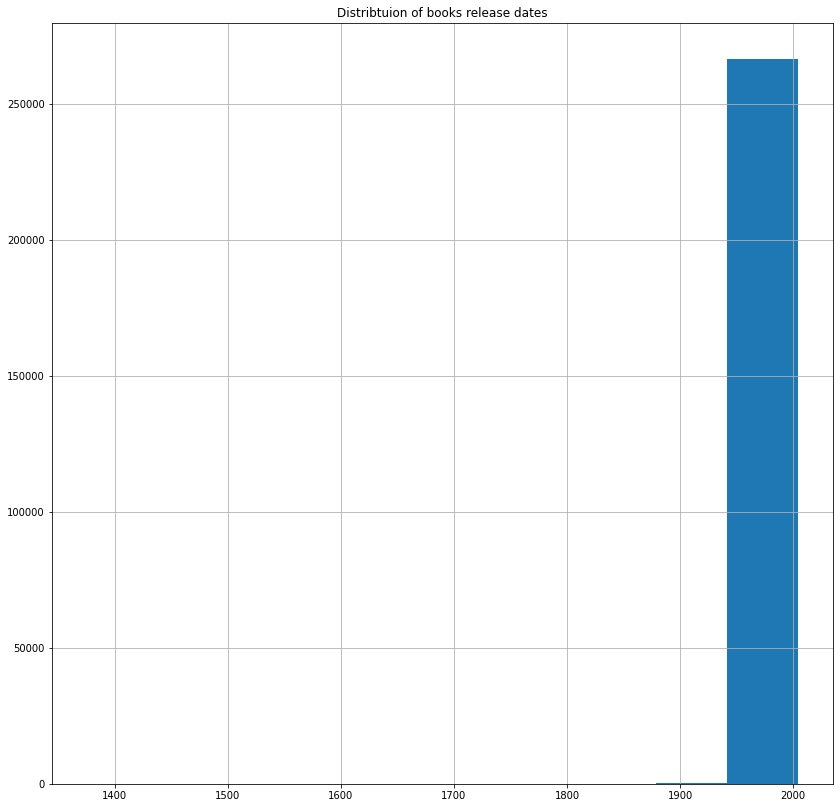

In [28]:
plt.figure(figsize=(14, 14))
books['Year'].hist()
plt.title('Distribtuion of books release dates')
plt.show()

### Almost all books are modern, i.e. written in the second half of the XX century

In [29]:
books['Book-Author'].value_counts()

Agatha Christie         632
William Shakespeare     567
Stephen King            524
Ann M. Martin           423
Carolyn Keene           373
                       ... 
Linda Jackson             1
Artiste C. Arthur         1
Emily Pearl Kingsley      1
Jean Cassels              1
Christopher  Biffle       1
Name: Book-Author, Length: 102022, dtype: int64

In [30]:
books['Publisher'].value_counts()

Harlequin                  7535
Silhouette                 4220
Pocket                     3905
Ballantine Books           3783
Bantam Books               3646
                           ... 
Polaris Books                 1
Hannover House                1
Amber Quill Press, LLC.       1
Lunchbox Press                1
Connaught                     1
Name: Publisher, Length: 16806, dtype: int64

### There is a lot of unique publishers and authors and, additionally, number of books published/written by them may vary significantly

In [31]:
books['ISBN'].nunique() == books['Book-Title'].nunique()

False

### Some books may have multiple ISBNs

In [32]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [33]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


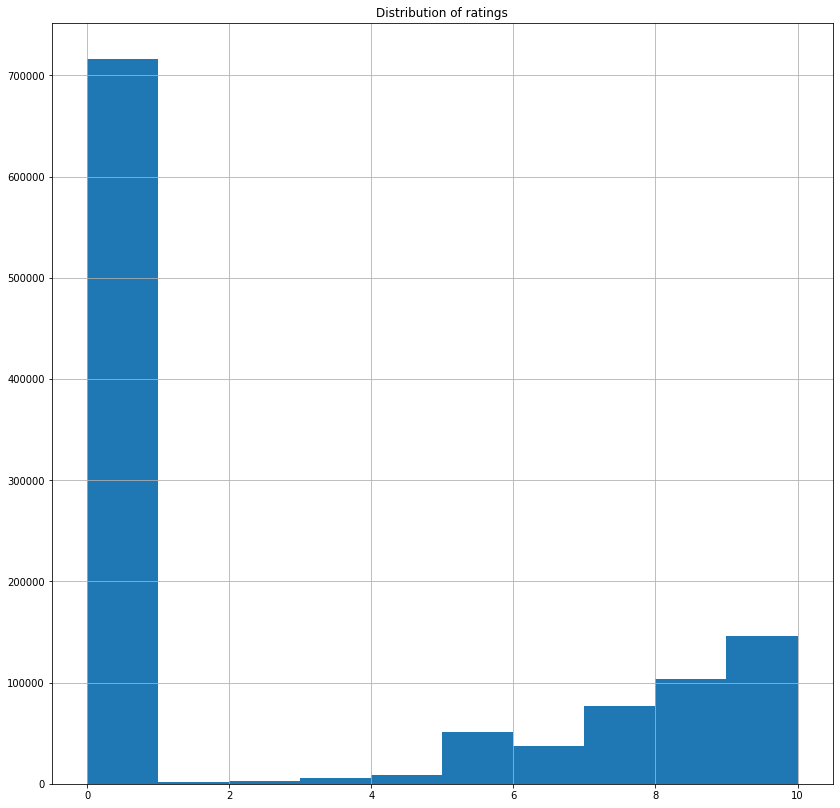

In [34]:
plt.figure(figsize=(14, 14))
ratings['Book-Rating'].hist()
plt.title('Distribution of ratings')
plt.show()

### Most of grades are 0, which is rather not reliable - users probably acted in emotions or some external factors could apply

In [35]:
ratings['Book-Rating'] = ratings['Book-Rating'].apply(lambda x: np.NaN if x == 0 else x)

In [36]:
ratings.dropna(how='any', inplace=True)

In [37]:
ratings.shape[0]

433671

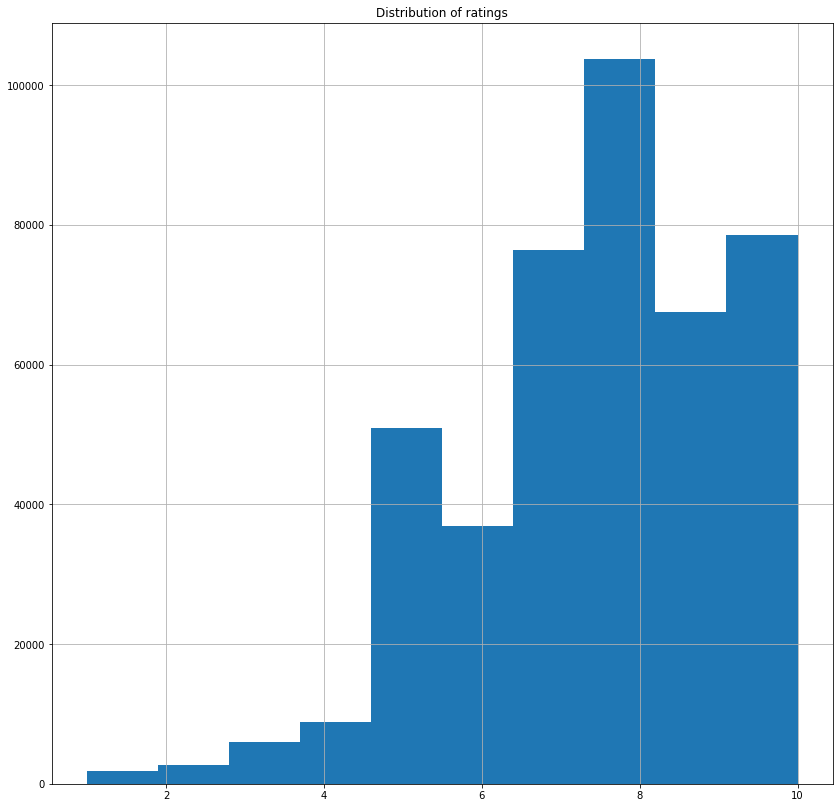

In [38]:
plt.figure(figsize=(14, 14))
ratings['Book-Rating'].hist()
plt.title('Distribution of ratings')
plt.show()

# Recommendation system

### Recommendation system is supposed to propose a book based on its average rating - it's assumed that every book should be graded at leat twice to provide more reliability - and user's reading history (to avoid suggesting a book user has read)

In [39]:
ratings['ISBN'].isin(books['ISBN']).value_counts()

True     383839
False     49832
Name: ISBN, dtype: int64

### Some rated books are not present in the 'books' dataset, thus they should be removed as there won't be necessary information about them

In [40]:
ratings_recommendations = ratings[ratings['ISBN'].isin(books['ISBN'])] 

In [41]:
ratings_recommendations.shape[0]

383839

### Each book should be graded at least twice, so each ISBN should be present at least two times:

In [42]:
books_to_consider = (ratings_recommendations['ISBN'].value_counts() > 1).apply(lambda x: np.NaN if x is False else x).dropna(how='any').index

In [43]:
books_to_consider

Index(['0316666343', '0971880107', '0385504209', '0312195516', '0060928336',
       '059035342X', '0142001740', '0446672211', '044023722X', '0452282152',
       ...
       '042518465X', '0345253892', '0671647482', '0060153016', '0307101711',
       '0452265622', '1566913578', '033035647X', '0689822855', '0060288132'],
      dtype='object', length=50423)

In [44]:
ratings_recommendations = ratings_recommendations[ratings_recommendations['ISBN'].isin(books_to_consider)]

In [45]:
ratings_recommendations.shape[0]

284429

In [46]:
ratings_recommendations.head()

,User-ID,ISBN,Book-Rating
8,276744,038550120X,7.0
16,276747,0060517794,9.0
19,276747,0671537458,9.0
20,276747,0679776818,8.0
24,276748,0747558167,6.0


In [47]:
books_recommendation = books.merge(ratings_recommendations.drop('User-ID', axis=1).groupby('ISBN').mean(), on='ISBN')\
                            .sort_values(['Book-Rating', 'Book-Author'], ascending=False)

In [48]:
books_recommendation.head(10)

,ISBN,Book-Title,Book-Author,Publisher,Year,Book-Rating
49612,0743466985,The Sisters of APF : The Indoctrination of Sor...,Zane,Atria Books,2003.0,10.0
47962,0615114776,A Twinkle In His Eye,Yvette M. Burton,Shooting Star Pub,2000.0,10.0
48807,0963056611,A Quest Among the Bewildered,Wulf Zendik,Zendik Communal Arts,2001.0,10.0
48210,1566191416,Frankenstein,Wollstonecraft Mary Shelley,Dorset Press,1993.0,10.0
24045,3498090275,Das Gesamtwerk.,Wolfgang Borchert,"Rowohlt, Reinbek",1996.0,10.0
43343,0330344951,Ross Poldark (Poldark Saga),Winston Graham,Pan Books - Macmillan UK,1996.0,10.0
49893,0385323301,Where the Red Fern Grows: The Story of Two Dog...,Wilson Rawls,Delacorte Press,1996.0,10.0
47337,0898158265,Composition With Cat: Lost Masterpieces of the...,William Warmack,Ten Speed Press,1997.0,10.0
32741,0679602895,Sophie's Choice (Modern Library),William Styron,Modern Library,1998.0,10.0
44400,0671666894,CDB!,William Steig,Aladdin,1987.0,10.0


In [49]:
books_recommendation.shape

(50423, 6)

### An average rating of each book is added to the 'books' dataset, which will now contain only graded books so these which can be proposed to users

### Recommendation system will suggest 5 top books - based on highest ratings - which a user did not read:

In [51]:
def recommendations(user: int) -> list:
    
    books_read, books_suggestion, item_no = list(ratings_recommendations[ratings_recommendations['User-ID'] == user]['ISBN']),\
        list(), 0
    
    while len(books_suggestion) < 5:  # 5 top books
        
        item = books_recommendation.iloc[item_no]
        if item['ISBN'] not in books_read:
            
            books_suggestion.append(item)
            
        item_no += 1
        
    print("\nBooks recommended for user with ID {} are:".format(user))
    for i in range(5):
        print("""\t"{}" written by {} and published by {} in {} with average rating {}"""\
                  .format(books_suggestion[i]['Book-Title'], books_suggestion[i]['Book-Author'], books_suggestion[i]['Publisher'],
                         int(books_suggestion[i]['Year']), round(books_suggestion[i]['Book-Rating'], 1))
             )
    
    return books_suggestion

### Recommendations for a user with ID 276747:

In [52]:
result = recommendations(276747)


Books recommended for user with ID 276747 are:
	"The Sisters of APF : The Indoctrination of Soror Ride Dick" written by Zane and published by Atria Books in 2003 with average rating 10.0
	"A Twinkle In His Eye" written by Yvette M. Burton and published by Shooting Star Pub in 2000 with average rating 10.0
	"A Quest Among the Bewildered" written by Wulf Zendik and published by Zendik Communal Arts in 2001 with average rating 10.0
	"Frankenstein" written by Wollstonecraft Mary Shelley and published by Dorset Press in 1993 with average rating 10.0
	"Das Gesamtwerk." written by Wolfgang Borchert and published by Rowohlt, Reinbek in 1996 with average rating 10.0


In [53]:
ratings_recommendations[ratings_recommendations['User-ID'] == 276747]

,User-ID,ISBN,Book-Rating
16,276747,0060517794,9.0
19,276747,0671537458,9.0
20,276747,0679776818,8.0


In [54]:
books_recommendation.iloc[0:5]

,ISBN,Book-Title,Book-Author,Publisher,Year,Book-Rating
49612,0743466985,The Sisters of APF : The Indoctrination of Sor...,Zane,Atria Books,2003.0,10.0
47962,0615114776,A Twinkle In His Eye,Yvette M. Burton,Shooting Star Pub,2000.0,10.0
48807,0963056611,A Quest Among the Bewildered,Wulf Zendik,Zendik Communal Arts,2001.0,10.0
48210,1566191416,Frankenstein,Wollstonecraft Mary Shelley,Dorset Press,1993.0,10.0
24045,3498090275,Das Gesamtwerk.,Wolfgang Borchert,"Rowohlt, Reinbek",1996.0,10.0


# Regression task

### A regression model will try to predict a future grades given by a user based on their information - age and location only in this case. Moreover, users must be filtered so that only those who have an age information remain

In [55]:
ratings.head()

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0
6,276736,3257224281,8.0
7,276737,0600570967,6.0


In [56]:
ratings = ratings.drop('ISBN', axis=1)  # column is no longer necessary

In [57]:
users.head()

,User-ID,Location,Age
0,1,usa,NaN
1,2,usa,18.0
2,3,russia,NaN
3,4,portugal,17.0
4,5,united kingdom,NaN


### We need only users for whom there is an informaion about their age as well as we need to filter that column to exclude some values, like 0 or aobve 100. As for their location, we will only consider top 7 countries to have enough data for each of them:

In [58]:
top_countries = users['Location'].value_counts()[:7].index

In [59]:
top_countries

Index(['usa', 'canada', 'united kingdom', 'germany', 'spain', 'australia',
       'italy'],
      dtype='object')

In [60]:
def filter_age(record):
    if record >= 18 and record < 100:  # only adults below 100 are considered
        return int(record)
    else:
        return np.NaN

In [61]:
users = users[users['Location'].isin(top_countries)]

In [62]:
users['Age'] = users['Age'].apply(lambda x: filter_age(x))

In [63]:
users = users.dropna(how='any')

In [64]:
users.shape

(127754, 3)

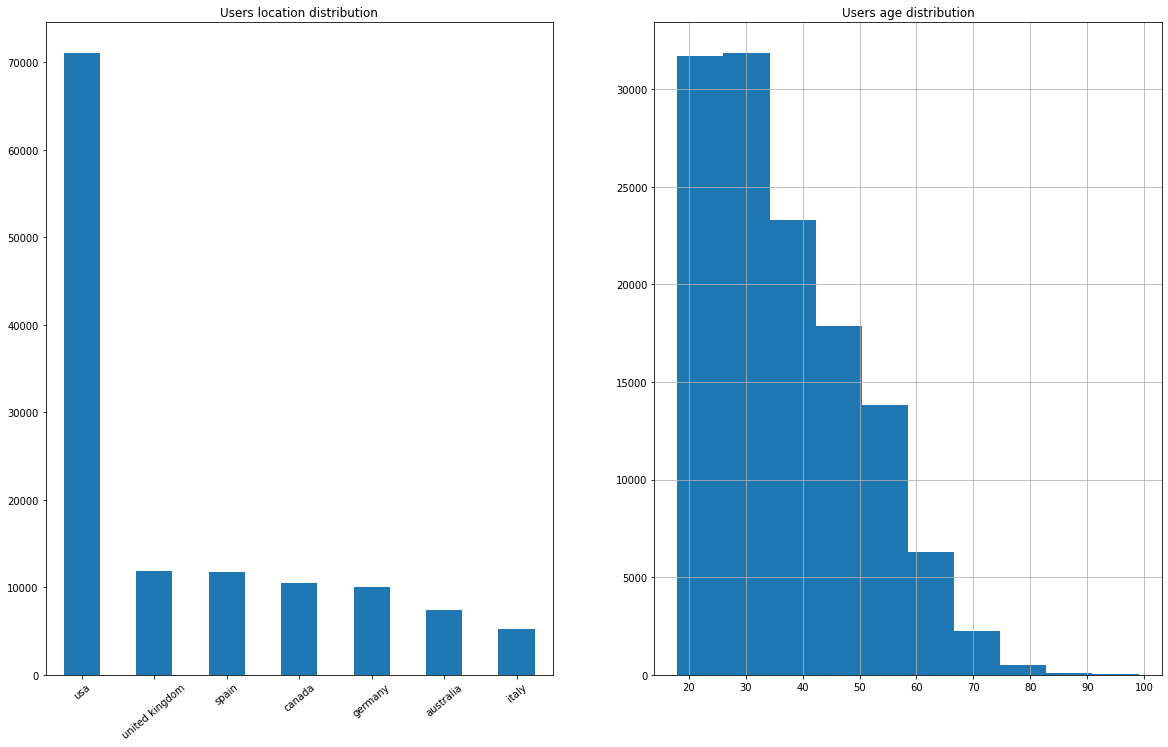

In [65]:
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
users['Location'].value_counts().plot(kind='bar', rot=40)
plt.title('Users location distribution')

plt.subplot(1, 2, 2)
users['Age'].hist()
plt.title('Users age distribution')

plt.show()

### Encoding users country data:

In [66]:
encoder_location = OneHotEncoder(drop='first', sparse=False)

In [67]:
encoded_countries = encoder_location.fit_transform(np.array(users['Location']).reshape(-1, 1))

In [68]:
encoded_countries

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [69]:
encoded_countries.shape

(127754, 6)

In [70]:
users_numeric = users.drop('Location', axis=1).reset_index()\
                        .join(pd.DataFrame(encoded_countries,
                                           columns=['location_' + str(i) for i in range(1, 7)],
                                          )
                             ).set_index('User-ID').drop('index', axis=1)

In [71]:
users_numeric

,Age,location_1,location_2,location_3,location_4,location_5,location_6
User-ID,,,,,,,
2,18.0,0.0,0.0,0.0,0.0,0.0,1.0
6,61.0,0.0,0.0,0.0,0.0,0.0,1.0
10,26.0,0.0,0.0,0.0,1.0,0.0,0.0
13,26.0,0.0,0.0,0.0,1.0,0.0,0.0
20,19.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
278846,23.0,1.0,0.0,0.0,0.0,0.0,0.0
278849,23.0,1.0,0.0,0.0,0.0,0.0,0.0
278851,33.0,0.0,0.0,0.0,0.0,0.0,1.0


### Scaling users age:

In [72]:
scaler_age = StandardScaler()

In [73]:
users_numeric['Age'] = scaler_age.fit_transform(np.array(users_numeric['Age']).reshape(-1, 1))

In [74]:
users_numeric.head(10)

,Age,location_1,location_2,location_3,location_4,location_5,location_6
User-ID,,,,,,,
2,-1.458549,0.0,0.0,0.0,0.0,0.0,1.0
6,1.817278,0.0,0.0,0.0,0.0,0.0,1.0
10,-0.849093,0.0,0.0,0.0,1.0,0.0,0.0
13,-0.849093,0.0,0.0,0.0,1.0,0.0,0.0
20,-1.382367,0.0,0.0,0.0,0.0,0.0,1.0
21,0.674548,0.0,0.0,0.0,1.0,0.0,0.0
24,-1.382367,0.0,1.0,0.0,0.0,0.0,0.0
25,1.360186,0.0,0.0,0.0,0.0,0.0,1.0
27,-0.392000,0.0,0.0,0.0,0.0,0.0,1.0


### Now we should consider users who are present in both datasets:

In [75]:
ids = np.intersect1d(users_numeric.index, ratings['User-ID'])

In [76]:
ids.shape

(37568,)

In [77]:
users_numeric = users_numeric[users_numeric.index.isin(ids)]

In [78]:
ratings = ratings[ratings['User-ID'].isin(ids)]

In [79]:
ratings.shape

(258586, 2)

### Merging two datasets:

In [80]:
data = ratings.merge(users_numeric.reset_index(), on='User-ID')

In [81]:
data

,User-ID,Book-Rating,Age,location_1,location_2,location_3,location_4,location_5,location_6
0,276745,10.0,-0.772911,0.0,1.0,0.0,0.0,0.0,0.0
1,276747,9.0,-0.925275,0.0,0.0,0.0,0.0,0.0,1.0
2,276747,9.0,-0.925275,0.0,0.0,0.0,0.0,0.0,1.0
3,276747,8.0,-0.925275,0.0,0.0,0.0,0.0,0.0,1.0
4,276747,7.0,-0.925275,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
258581,276681,8.0,0.446002,0.0,0.0,0.0,0.0,0.0,1.0
258582,276681,8.0,0.446002,0.0,0.0,0.0,0.0,0.0,1.0
258583,276681,7.0,0.446002,0.0,0.0,0.0,0.0,0.0,1.0
258584,276681,10.0,0.446002,0.0,0.0,0.0,0.0,0.0,1.0


### Preparing a regression model:

In [82]:
inputs, target = data.drop(['User-ID', 'Book-Rating'], axis=1), data['Book-Rating']

In [83]:
input_train, input_test, target_train, target_test = train_test_split(inputs, target, test_size=.15)

### Random Forest will be used for a regression task:

In [84]:
RFF = RandomForestRegressor()

In [85]:
grid_parameters = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['log2', 'sqrt', 1, 2],
    'min_samples_split': [2, 4, 6],
}

In [86]:
grid = GridSearchCV(estimator=RFF,
                   param_grid=grid_parameters,
                   n_jobs=-1,
                   cv=5,
                   verbose=True,
                   )

In [87]:
t0 = time()
grid.fit(input_train, target_train)
t1 = time()

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [88]:
grid.best_estimator_

RandomForestRegressor(max_features='sqrt', min_samples_split=4,
                      n_estimators=150)

In [89]:
grid.best_score_

0.0325316848482865

In [90]:
print('Searching took {} seconds'.format(round(t1 - t0, 2)))

Searching took 671.45 seconds


In [91]:
target_predicted = grid.predict(input_test)

In [92]:
r2_score(y_true=target_test, y_pred=target_predicted.round())

0.008319017320906563

### As one could expect, prediction performs quite poorly since there are only two paramters supposed to describe ratings

In [96]:
with open('data/model.pkl', 'wb') as file:
    pickle.dump(grid.best_estimator_, file)